In [337]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma, digamma, loggamma
from scipy.stats import gamma, norm


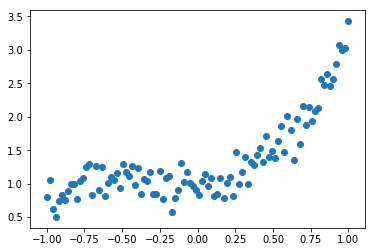

In [446]:
# Generate a dataset

# input variables
X = np.linspace(-1, 1, 100)
error_term = np.random.normal(X) * 0.2

# target variables
t = (1 + X ** 2 + X ** 3 + error_term)[:, None]

plt.scatter(X, t)
plt.show()

In [448]:
# Make design matrix. (3.16)

def get_design_matrix(X, phi):
    design = []
    for x in X:
        design.append(phi(x))
    design = np.vstack(design)
    
    return design
 

In [449]:
# Get latent variables' params

# q(alpha) = Gam(alpha|a_N, b_N)   (10.93)

def get_qalpha_params(a_0, b_0, M, E_wTw):
    
    a_N = a_0 + M / 2.           # (10.94)
    b_N = b_0 + 0.5 * E_wTw      # (10.95)
    
    return a_N, b_N  

# q(w) = N(w|m_N, S_N)             (10.99)

def get_qw_params(E_alpha, beta, design, t):
    S_N = np.linalg.inv(E_alpha + beta * design.T @ design)    # (10.101)
    m_N = beta * S_N @ design.T @ t                            # (10.100)
    
    return m_N, S_N


In [454]:
# Perform variational linear regrssion
# beta : hyperparameter - precision of target t
# a_0, b_0 : hyperparamete of gamma distribution p(alpha)

def variational_linear_regression(phi, X, t, beta=1, a_0=1e-7, b_0=1e-7):
    design = get_design_matrix(X, phi)
    M = design.shape[-1]

    # initial guess
    E_alpha = 0

    ITERATION = 100
    for _ in range(ITERATION):
        m_N, S_N = get_qw_params(E_alpha, beta, design, t)
        E_wTw = (m_N.T @ m_N + np.trace(S_N))[0, 0]           # (10.104)

        a_N, b_N = get_qalpha_params(a_0, b_0, M, E_wTw)
        E_alpha = a_N / b_N                                   # (10.102)
        
    return m_N, S_N, a_N, b_N
    

    

In [451]:
# get predictive distribution p(new_t|new_x, t)'s parameters 

def get_predictive_params(x, m_N, S_N, beta):
    phi_x = phi(x)
    mean = m_N.T @ phi_x                             # (10.105)
    variance = 1. / beta + phi_x.T @ S_N @ phi(x)    # (10.106)
    
    return mean, variance


In [452]:
# Caculate ELBO (Evidence Lower BOund)

# (10.108)
def get_E_ln_p_tw(beta, m_N, S_N, design, t):
    N = len(t)
    v1 = N / 2. * np.log(beta / (2. * np.pi))
    v2 = (-beta / 2. * t.T @ t)[0, 0]
    v3 = (beta * m_N.T @ design.T @ t)[0, 0]
    v4 = -beta / 2. * np.trace(design.T @ design * (m_N @ m_N.T + S_N))

    return v1 + v2 + v3 + v4
    
# (10.109)
def get_E_ln_p_walpha(M, a_N, b_N, m_N, S_N):
    v1 = -M / 2. * np.log(2 * np.pi)
    v2 = M / 2. * (digamma(a_N) - np.log(b_N))
    v3 = (-a_N / (2 * b_N) * (m_N.T @ m_N + np.trace(S_N)))[0, 0]
    
    return v1 + v2 + v3

# (10.110)
def get_E_ln_p_alpha(a_0, b_0, a_N, b_N):
    v1 = a_0 * np.log(b_0)
    v2 = (a_0 - 1.) * (digamma(a_N) - np.log(b_N))
    v3 = -b_0 * a_N - np.abs(loggamma(a_0))
    
    return v1 + v2 + v3

# (10.111)
def get_negtive_E_ln_q_w(S_N, M):
    v1 = 0.5 * np.log(np.linalg.det(S_N))
    v2 = M / 2. * (1. + np.log(2. * np.pi))
    return v1 + v2

# (10.112)
def get_negative_E_ln_q_alpha(a_N, b_N):
    v1 = np.abs(loggamma(a_N))
    v2 = -(a_N - 1.) * digamma(a_N)
    v3 = -np.log(b_N)
    v4 = a_N
    
    return v1 + v2 + v3 + v4

def get_ELBO(X, phi, beta, m_N, S_N, t, a_0, b_0, a_N, b_N):
    design = get_design_matrix(X, phi)
    M = design.shape[-1]
    
    E_ln_p_tw = get_E_ln_p_tw(beta, m_N, S_N, design, t)
    E_ln_p_walpha = get_E_ln_p_walpha(M, a_N, b_N, m_N, S_N)
    E_ln_p_alpha = get_E_ln_p_alpha(a_0, b_0, a_N, b_N)
    negtive_E_ln_q_w = get_negtive_E_ln_q_w(S_N, M)
    negative_E_ln_q_alpha = get_negative_E_ln_q_alpha(a_N, b_N)

    return E_ln_p_tw + E_ln_p_walpha + E_ln_p_alpha + negtive_E_ln_q_w + negative_E_ln_q_alpha



In [ ]:
# Define polynomial basis functions

def phi1(x):
    return np.array([1, x])

def phi2(x):
    return np.array([1, x, x ** 2])

def phi3(x):
    return np.array([1, x, x ** 2, x ** 3])

def phi4(x):
    return np.array([1, x, x ** 2, x ** 3, x ** 4])

def phi5(x):
    return np.array([1, x, x ** 2, x ** 3, x ** 4, x ** 5])

def phi6(x):
    return np.array([1, x, x ** 2, x ** 3, x ** 4, x ** 5, x ** 6])

def phi7(x):
    return np.array([1, x, x ** 2, x ** 3, x ** 4, x ** 5, x ** 6, x ** 7])

def phi8(x):
    return np.array([1, x, x ** 2, x ** 3, x ** 4, x ** 5, x ** 6, x ** 7, x ** 8])

phis = [phi1, phi2, phi3, phi4, phi5, phi6, phi7, phi8]


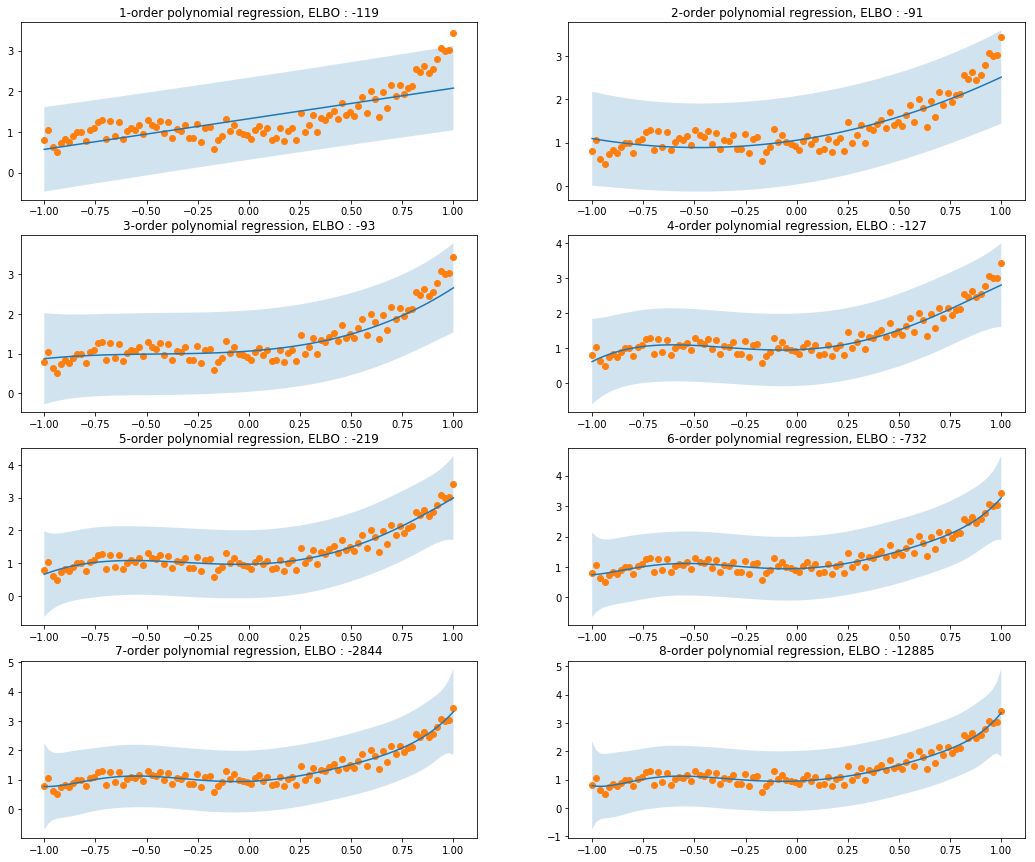

In [455]:
# Results 

plt.figure(figsize=[18, 15])

ELBOs = []
for i, phi in enumerate(phis):    
    m_N, S_N, a_N, b_N = variational_linear_regression(phi, X, t)
    
    means = []
    variances = []
    for x in X:
        mean, variance = get_predictive_params(x, m_N, S_N, beta)
        means.append(mean)
        variances.append(variance)
    
    means = np.array(means)[:, 0]
    variances = np.array(variances)
    
    ELBO = get_ELBO(X, phi, beta, m_N, S_N, t, a_0, b_0, a_N, b_N)
    ELBOs.append(ELBO)
    
    plt.subplot(4, 2, i + 1)
    plt.title(str(i + 1) + '-order polynomial regression, ELBO : ' + str(int(ELBO)))
    plt.plot(X, means)
    plt.fill_between(X, means - variances, means + variances, alpha=0.2)
    plt.scatter(X, t)
    
plt.show()


    